In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
%cd german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
/content/german-traffic-signs


In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
# load data from pickle file
with open('train.p', 'rb') as f:   #rb is for read binary
    train_data = pickle.load(f)
with open('valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('test.p', 'rb') as f:
    test_data = pickle.load(f)
    
print(type(train_data)) #its a dict type data with "features"(image data) and "lables"

# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

#check data shape
print(X_train.shape) #(34799, 32, 32, 3) --34799 images..each image of 32 X 32 pixels and 3 channels(b,g,r)
print(y_train.shape) #(34799,) -- 34799 lables
print(X_test.shape)
print(X_val.shape)

#some tests whether data has been correctly loaded from file
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

<class 'dict'>
(34799, 32, 32, 3)
(34799,)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [0]:
#reading the csv file
data = pd.read_csv('signnames.csv')
  
num_of_samples=[] #will hold number of images for each lable

cols = 5   #how many we want to show in one row
num_classes = 43  #total lables we have

#these we are just making boxes/space for images
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50)) #5inch X 50inch box
fig.tight_layout()  #so that the boxes do not overlap
#print(fig) #this will just shows blank boxes/space

#now lets load images there in space
for i in range(cols):
    #j--index of current row and row--data of current row
    #j --will go from 0-43 as we have 43 rows in signnames.csv
    for j, row in data.iterrows(): 
        x_selected = X_train[y_train == j] 
        #y_train == j returns [False True ... True False]
        #and all places where we have True are copied to x_selected
        
        #print(x_selected.shape) --(180, 32, 32, 3)..180 images for a label, all of 32 X32 pixels and 3 channels
        
        #random.randint(0,(len(x_selected) - 1)) --show some random image from x_selected
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])   #show title in centre
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


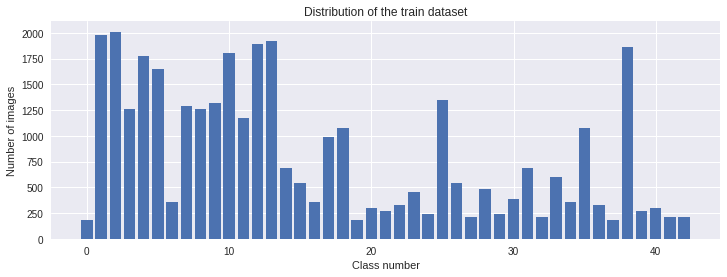

In [0]:
# we show a bar graph of number of images in each class

print(num_of_samples) #will show number of images for each lable

plt.figure(figsize=(12, 4))   #12 X 4 inches area

#plt.bar(x,y) -- range(0, num_classes) will give [0,1,2..43] and num_of_samples will give [100,20,200.....132]
#so this function will plot corresponding x and y values
plt.bar(range(0, num_classes), num_of_samples)

plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [0]:
#GRAYSCALE A IMAGE

#original shape of image
print(X_train[1000].shape) #(32, 32, 3)

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
print(img.shape)   #(32, 32)

(32, 32, 3)
(32, 32)


In [0]:
#EQUALISE INTENSITY OF IMAGE--sharpen the dull parts of image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)

print(img.shape)

(32, 32)


In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255  #regularization
    #note here that the image returned after dividing pixels by 255 cannot be shown using cv2.imshow. 
    #Because pixel intensity is not lying between 0-255 anymore.
    return img

In [0]:
#call preprocess function on all data sets

#map function will pick each element of X_train one by one, call preprocess function on it 
#and later we can store the results of the returned values to a new array
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

print(X_train.shape) #(34799, 32, 32) --channels is not there

#but we need to provide the number of channels(1 in our grayscale case) as convolution neural networks would need this info
X_train = X_train.reshape(34799, 32, 32, 1) #added 1 channel
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(34799, 32, 32)


In [0]:
#one hot encoding of lables
#we will not use lables 0-43, so that the network does not assume that label 30 is powerful then label 20..
#instead convert them to binary values--see Softmax.mp4 for best explaination

#print(y_train[1000])  #before encoding --ouputs 36

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

#print(y_train[1000])  #before encoding --36
#outputs [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

In [0]:
#define conv network
def leNet_model():
    model=Sequential()
    model.add(Conv2D(60,(5,5),input_shape=(32,32,1), activation='relu')) #60 filters(kernels) each of size 5X5
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))   #kernel size 2X2
    model.add(Conv2D(30,(3,3),activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())   #flattening
    model.add(Dense(500, activation='relu'))   #fully connected layer of 500 neurons
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='softmax'))   #output softmax layer
    
    #compile model
    #Adam is the optimizer. and we are using categorical_crossentropy() for calculating loss here
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

    return model 

In [0]:
model=leNet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 10s 290us/step - loss: 1.8412 - acc: 0.5006 - val_loss: 0.5395 - val_acc: 0.8447
Epoch 2/10
34799/34799 [==============================] - 5s 138us/step - loss: 0.3633 - acc: 0.8883 - val_loss: 0.2936 - val_acc: 0.9213
Epoch 3/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.1789 - acc: 0.9462 - val_loss: 0.2156 - val_acc: 0.9463
Epoch 4/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.1174 - acc: 0.9639 - val_loss: 0.1928 - val_acc: 0.9506
Epoch 5/10
34799/34799 [==============================] - 5s 138us/step - loss: 0.0833 - acc: 0.9744 - val_loss: 0.1593 - val_acc: 0.9594
Epoch 6/10
34799/34799 [==============================] - 5s 138us/step - loss: 0.0625 - acc: 0.9807 - val_loss: 0.1611 - val_acc: 0.9635
Epoch 7/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.0524 - acc: 0.9838 - val_loss: 0.1564 - 

Text(0.5, 0, 'epoch')

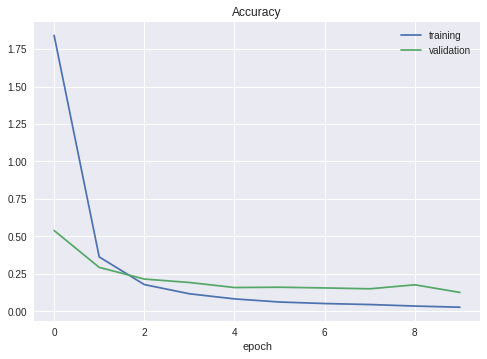

In [0]:
#training our model
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

#history.history gives 4 things training_loss, training_accuracy, val_loss, val_accuracy

plt.plot(history.history['loss'])  #1 line
plt.plot(history.history['val_loss'])  #2 line
plt.legend(['training', 'validation']) #lables for 1,2 line
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
#testing our model
score=model.evaluate(X_test, y_test, verbose=0)
print('Test Score', score[0])
print('Test Accuracy', score[1])

Test Score 0.20758314979803155
Test Accuracy 0.9527315914961241


(946, 1300, 3)


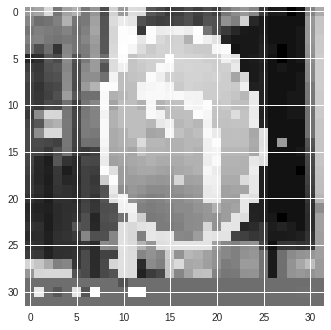

In [0]:
#predict for image from internet
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)

#image=cv2.imread('E:\\self_driving_cars_resources\\internet1.jpg')

image = np.asarray(image)
print(image.shape)  #(946, 1300, 3)
image = cv2.resize(image, (32, 32))   #(32,32)
image = preprocess(image)   #(32,32)
#now we cannot show it using cv2.imshow as pixel intenisty has been divided by 255

#since we cannot show using cv2.ismshow we will use matplotlib.plt
#plt always expects us to specify number of channels in input image. 
#for a gray image, we need to specify channel using cmap = plt.get_cmap('gray')
plt.imshow(image, cmap = plt.get_cmap('gray'))


#need to add number of channels as is must for CNN
image = image.reshape(1, 32, 32, 1)   #(1, 32, 32, 1)-- 1 image of 32 X 32 having 1 channel

In [0]:
print("predicted sign: "+ str(model.predict_classes(image)))

predicted sign: [12]
